# Name: Nalet Meinen

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from IPython.display import clear_output

# Define which device to use for computations
# If you have gpu, use 'cuda'
device = torch.device('cuda')
#device = torch.device('cpu')

# Assignment 1 ATML 2021

In [2]:
!nvidia-smi
if not os.path.isfile('dataset.py'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment1/dataset.py" "dataset.py"

Tue Mar 30 11:26:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Task 1. Prepare data for training and model selection

PyTorch torchvision module provides you with some predesigned datasets. Like the MNIST dataset, that we are going to use (https://pytorch.org/vision/0.8/_modules/torchvision/datasets/mnist.html#MNIST). Let us build a simple MNIST dataset and visualise some samples.


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
60000
5


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


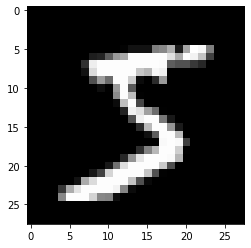

In [3]:
mnist_dataset = torchvision.datasets.MNIST(root=".", train=True, download=True)
print(len(mnist_dataset))
image, label = mnist_dataset[0]
plt.imshow(image, cmap='gray')
print(label)

For the needs of this assignment you will have to implement a similar Dataset class which will yield an image pair and a label equal to the mode 10 sum of the labels in the pair. 

### MnistPairs dataset

Implement the __getitem__ method in the dataset.py file. Build training and test sets with the 'right' and 'left' orders of the digits. Split the both training sets into training and validation sets with 90% and 10% of the data respectively. Concatenate the validation sets into one with both 'right' and 'test' orders. The same should be done with the test sets. Visualise some samples from the constructed datasets.

In [4]:
from dataset import MnistPairs

Length of dataset: 30000


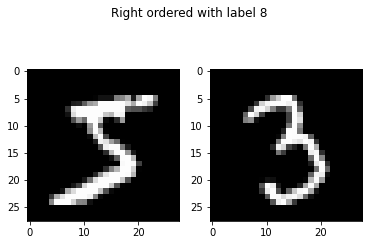

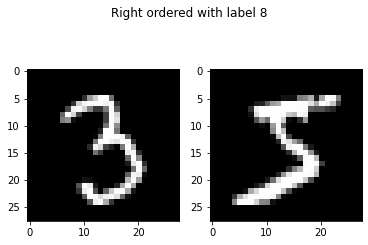

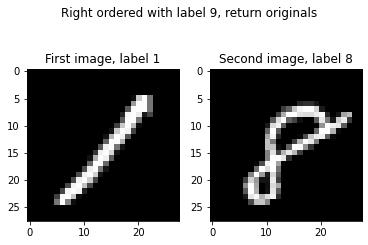

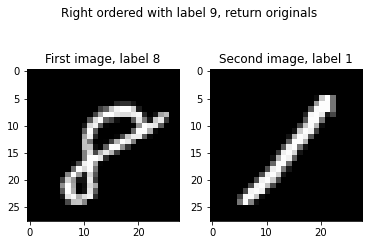

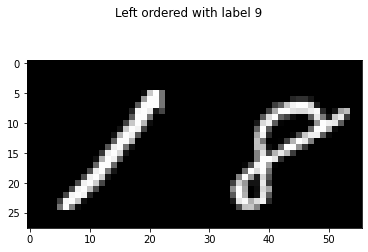

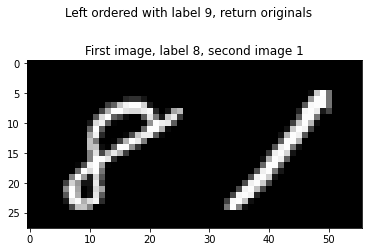

In [5]:
dataset = MnistPairs(root=".", train=True, download=True, order='right')
print("Length of dataset:",len(dataset))
item = dataset[0]
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.suptitle("Right ordered with label {}".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left')
item = dataset[0]
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.suptitle("Right ordered with label {}".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='right', return_original_labels=True)
item = dataset[len(dataset)-1] # test last item
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}".format(item[3]))
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.title("Second image, label {}".format(item[4]))
plt.suptitle("Right ordered with label {}, return originals".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left', return_original_labels=True)
item = dataset[len(dataset)-1] # test last item
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}".format(item[3]))
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.title("Second image, label {}".format(item[4]))
plt.suptitle("Right ordered with label {}, return originals".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='right', return_original_labels=True, concatenated=True)
item = dataset[len(dataset)-1] # test last item
plt.imshow(item[0], cmap='gray')
plt.suptitle("Left ordered with label {}".format(item[1]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left', return_original_labels=True, concatenated=True)
item = dataset[len(dataset)-1] # test last item
plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}, second image {}".format(item[2], item[3]))
plt.suptitle("Left ordered with label {}, return originals".format(item[1]))
plt.show()

In [6]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])

dataset_left = MnistPairs(root=".", train=True, download=True, transform=transforms, order='left', return_original_labels=True, concatenated=True)
dataset_left_test_set = MnistPairs(root=".", train=False, download=True, transform=transforms, order='left', return_original_labels=True, concatenated=True)
dataset_left_train_set, dataset_left_val_set = torch.utils.data.random_split(dataset_left, [27000, 3000])
#Right
dataset_right = MnistPairs(root=".", train=True, download=True, transform=transforms, order='right', return_original_labels=True, concatenated=True)
dataset_right_test_set = MnistPairs(root=".", train=False, download=True, transform=transforms, order='right', return_original_labels=True, concatenated=True)
dataset_right_train_set, dataset_right_val_set = torch.utils.data.random_split(dataset_right, [27000, 3000])
#Both
dataset_both_train_set = torch.utils.data.ConcatDataset([dataset_left_train_set, dataset_right_train_set])
dataset_both_test_set = torch.utils.data.ConcatDataset([dataset_left_test_set, dataset_right_test_set])
dataset_both_val_set = torch.utils.data.ConcatDataset([dataset_left_val_set, dataset_right_val_set])

print("Length of concatenated train is {}, length of concatenated test is {}, length of concatenated val is {}.".format(len(dataset_both_train_set), len(dataset_both_test_set), len(dataset_both_val_set)))

Length of concatenated train is 54000, length of concatenated test is 10000, length of concatenated val is 6000.


### Label and Pair Distribution

Visualize the distribution of the labels and pairs in the training, validation and testing sets.

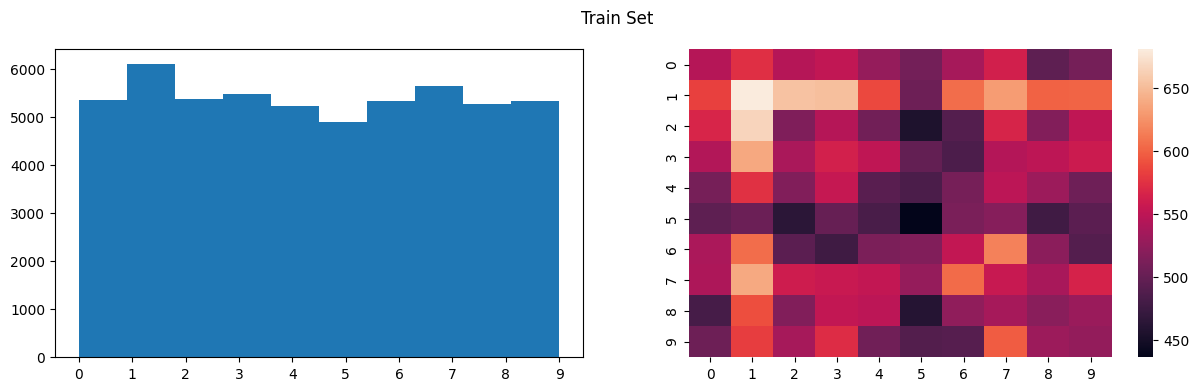

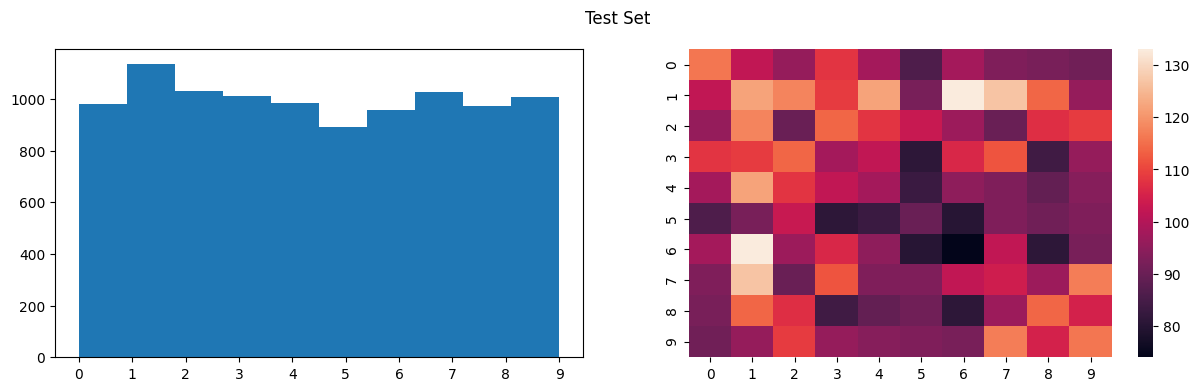

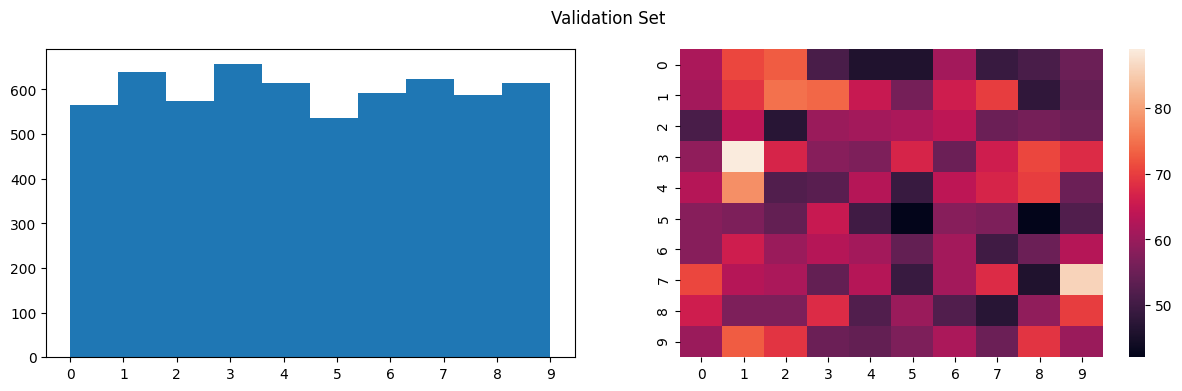

In [7]:
import seaborn as sns; sns.set_theme()

def calculate_distribution_of_labels(dataset, title=None):
    hist = []
    pairs = np.zeros((10,10))
    for item in dataset:
        hist.append(item[2])
        pairs[item[2], item[3]] += 1
    plt.rcdefaults()
    plt.subplots(1,2,figsize=(15,4))
    plt.suptitle(title)
    plt.subplot(1,2,2), sns.heatmap(pairs)
    plt.subplot(1,2,1), plt.hist(hist)
    plt.xticks(range(10))
    plt.show()
    plt.rcdefaults()

calculate_distribution_of_labels(dataset_both_train_set,title="Train Set")
calculate_distribution_of_labels(dataset_both_test_set,title="Test Set")
calculate_distribution_of_labels(dataset_both_val_set,title="Validation Set")


If the distribution of the labels in the test set differs from the one in the training set, we should expect a different performance of the model on the test set.

## Task 2. Design training settings

Having the MnistPairs dataset implemented, we can now nicely wrap in with a DataLoader class for the ease of training.

In [8]:
batch_size=128
#Left
train_left_loader = torch.utils.data.DataLoader(dataset_left_train_set, batch_size=batch_size, shuffle=True)
val_left_loader = torch.utils.data.DataLoader(dataset_left_val_set, batch_size=batch_size, shuffle=False)
test_left_loader = torch.utils.data.DataLoader(dataset_left_test_set, batch_size=batch_size, shuffle=False)
#Right
train_right_loader = torch.utils.data.DataLoader(dataset_right_train_set, batch_size=batch_size, shuffle=True)
val_right_loader = torch.utils.data.DataLoader(dataset_right_val_set, batch_size=batch_size, shuffle=False)
test_right_loader = torch.utils.data.DataLoader(dataset_right_test_set, batch_size=batch_size, shuffle=False)
#Both
train_both_loader = torch.utils.data.DataLoader(dataset_both_train_set, batch_size=batch_size, shuffle=True)
val_both_loader = torch.utils.data.DataLoader(dataset_both_val_set, batch_size=batch_size, shuffle=False)
test_both_loader = torch.utils.data.DataLoader(dataset_both_test_set, batch_size=batch_size, shuffle=False)

Define a bunch of models to test, the loss function and the optimizers.

In [9]:
class Model01(torch.nn.Module):
    def __init__(self):
        super(Model01, self).__init__()
        self.main = nn.Sequential(nn.ReLU(),
                                  nn.Linear(56*28, 784),
                                  nn.ReLU(),
                                  nn.Linear(784, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 10),
                                  nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        out = x.view(x.size(0), 56*28)
        out = self.main(out)
        return out

class Model02(torch.nn.Module):
    def __init__(self):
        super(Model02, self).__init__()
        self.main = nn.Sequential(nn.ReLU(),
                                  nn.Linear(56*28, 2048),
                                  nn.ReLU(),
                                  nn.Linear(2048, 1024),
                                  nn.ReLU(),
                                  nn.Linear(1024, 10),
                                  nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        out = x.view(x.size(0), 56*28)
        out = self.main(out)
        return out

class Model03(torch.nn.Module):
    def __init__(self):
        super(Model03, self).__init__()
        self.main = nn.Sequential(nn.ReLU(),
                                  nn.Linear(56*28, 784),
                                  nn.Linear(784, 256),
                                  nn.Linear(256, 10))
    
    def forward(self, x):
        out = x.view(x.size(0), 56*28)
        out = self.main(out)
        return out

Let us also define the metric we are going to use for the assesment of the model. We will simply use the accuracy of the model.

In [10]:
def accuracy(labels, predictions):
    return correct_predictions / len_dataset

Write the training loop.

In [11]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels, _, _) in enumerate((dataloader)):
        ## TODO: fill the training loop
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

def train_model(taskname, train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, model_class):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train(model, train_dataloader, optimizer, loss_fn)
        train_loss, train_accuracy = evaluate_model(model, train_dataloader, loss_fn)
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

    best_model = model_class()
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch


Write the evaluation code.

In [12]:
def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for iteration, (images, labels, _, _) in enumerate((dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())

    ## Store and print average test loss and accuracy
    average_loss = sum(losses) / len(losses)
    accuracy = 100 * correct_predictions / len(dataloader.dataset)
    return average_loss, accuracy

In [13]:
def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = evaluate_model(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

## Task 3. Train on training 'right' set.

Train the models on training 'right' set and select the best model on the validation set.

Epoch 1/15: train_loss: 1.9037, train_accuracy: 38.4815, val_loss: 1.9206, val_accuracy: 36.6333
Epoch 2/15: train_loss: 1.3686, train_accuracy: 56.7963, val_loss: 1.4345, val_accuracy: 52.2000
Epoch 3/15: train_loss: 1.0604, train_accuracy: 67.1667, val_loss: 1.1990, val_accuracy: 59.8000
Epoch 4/15: train_loss: 0.8670, train_accuracy: 73.9259, val_loss: 1.0671, val_accuracy: 64.6667
Epoch 5/15: train_loss: 0.7210, train_accuracy: 79.0889, val_loss: 0.9819, val_accuracy: 67.8667
Epoch 6/15: train_loss: 0.6177, train_accuracy: 82.3000, val_loss: 0.9502, val_accuracy: 68.7667
Epoch 7/15: train_loss: 0.5174, train_accuracy: 86.0556, val_loss: 0.9072, val_accuracy: 69.9000
Epoch 8/15: train_loss: 0.4453, train_accuracy: 88.2815, val_loss: 0.9048, val_accuracy: 70.2333
Epoch 9/15: train_loss: 0.3667, train_accuracy: 91.2148, val_loss: 0.8870, val_accuracy: 70.8333
Epoch 10/15: train_loss: 0.3134, train_accuracy: 92.8444, val_loss: 0.9053, val_accuracy: 71.5000
Epoch 11/15: train_loss: 0.25

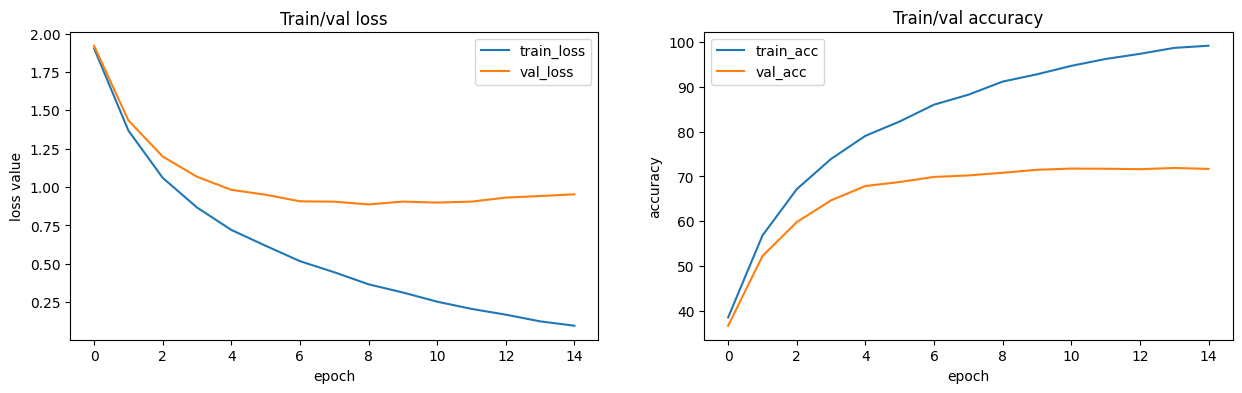

Best Epoch: 14 Average loss: 0.9415338883797327 Accuracy: 71.9
Epoch 1/15: train_loss: 1.4186, train_accuracy: 55.5963, val_loss: 1.4833, val_accuracy: 50.8667
Epoch 2/15: train_loss: 0.8867, train_accuracy: 72.7370, val_loss: 1.0511, val_accuracy: 64.8000
Epoch 3/15: train_loss: 0.6308, train_accuracy: 82.1926, val_loss: 0.9054, val_accuracy: 70.7000
Epoch 4/15: train_loss: 0.4427, train_accuracy: 88.1037, val_loss: 0.8297, val_accuracy: 72.7333
Epoch 5/15: train_loss: 0.2888, train_accuracy: 93.5407, val_loss: 0.7653, val_accuracy: 76.0333
Epoch 6/15: train_loss: 0.1982, train_accuracy: 95.9000, val_loss: 0.7861, val_accuracy: 75.6333
Epoch 7/15: train_loss: 0.1202, train_accuracy: 98.3111, val_loss: 0.7844, val_accuracy: 75.7667
Epoch 8/15: train_loss: 0.0695, train_accuracy: 99.4963, val_loss: 0.8220, val_accuracy: 76.0000
Epoch 9/15: train_loss: 0.0394, train_accuracy: 99.8889, val_loss: 0.8468, val_accuracy: 75.8000
Epoch 10/15: train_loss: 0.0223, train_accuracy: 99.9963, val_lo

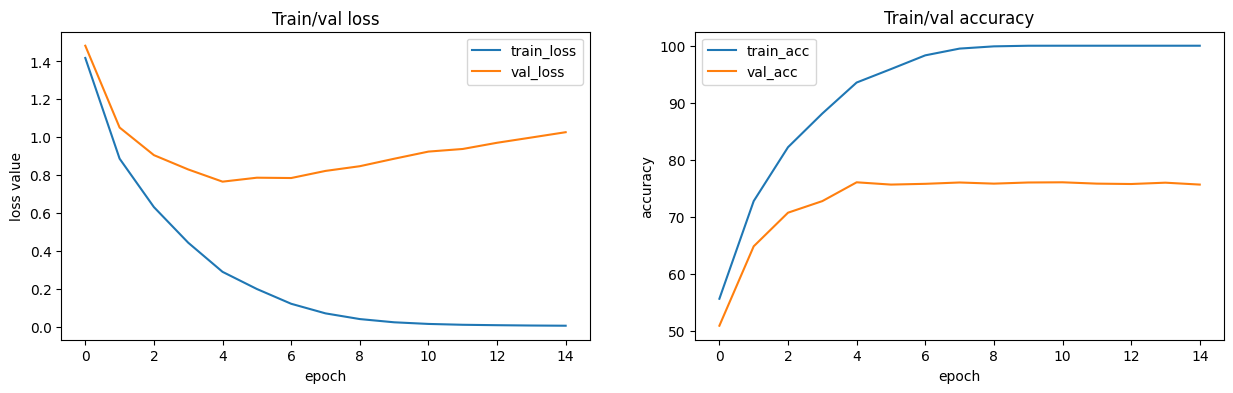

Best Epoch: 5 Average loss: 0.765288382768631 Accuracy: 76.03333333333333
Epoch 1/15: train_loss: 2.2837, train_accuracy: 14.8259, val_loss: 2.3078, val_accuracy: 11.6667
Epoch 2/15: train_loss: 2.2724, train_accuracy: 15.6741, val_loss: 2.3107, val_accuracy: 10.6333
Epoch 3/15: train_loss: 2.2613, train_accuracy: 16.9222, val_loss: 2.3173, val_accuracy: 12.1000
Epoch 4/15: train_loss: 2.2465, train_accuracy: 17.7296, val_loss: 2.3242, val_accuracy: 10.4667
Epoch 5/15: train_loss: 2.2397, train_accuracy: 17.8000, val_loss: 2.3365, val_accuracy: 11.8667
Epoch 6/15: train_loss: 2.2271, train_accuracy: 18.4481, val_loss: 2.3421, val_accuracy: 10.4667
Epoch 7/15: train_loss: 2.2142, train_accuracy: 19.7259, val_loss: 2.3443, val_accuracy: 10.9333
Epoch 8/15: train_loss: 2.2042, train_accuracy: 20.3630, val_loss: 2.3529, val_accuracy: 10.6333
Epoch 9/15: train_loss: 2.1944, train_accuracy: 20.6926, val_loss: 2.3641, val_accuracy: 10.8667
Epoch 10/15: train_loss: 2.1914, train_accuracy: 19.9

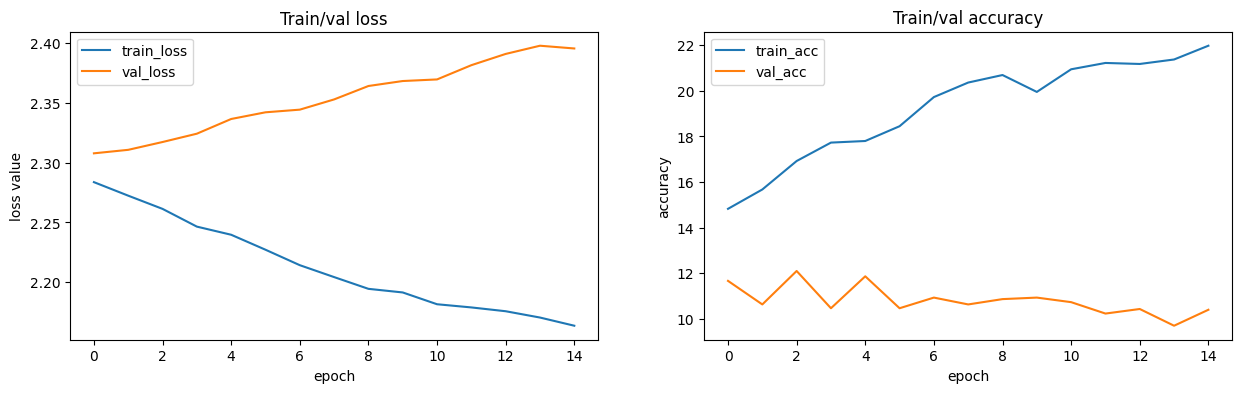

Best Epoch: 3 Average loss: 2.3172645966211953 Accuracy: 12.1


In [14]:
loss_fn = nn.CrossEntropyLoss()

model1 = Model01()
model1 = model1.to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_right_results1 = train_model("train_right1", train_right_loader, val_right_loader, model1, optimizer1, loss_fn, 15, Model01)
plot_results(train_right_results1, test_right_loader, val_right_loader)

model2 = Model02()
model2 = model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_right_results2 = train_model("train_right2", train_right_loader, val_right_loader, model2, optimizer2, loss_fn, 15, Model02)
plot_results(train_right_results2, test_right_loader, val_right_loader)

model3 = Model03()
model3 = model3.to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_right_results3 = train_model("train_right3", train_right_loader, val_right_loader, model3, optimizer3, loss_fn, 15, Model03)
plot_results(train_right_results3, test_right_loader, val_right_loader)

## Task 4. Train on concatenated training set.

Train the models on concatenated training set and select the best model on the validation set.

Epoch 1/15: train_loss: 1.3856, train_accuracy: 55.6056, val_loss: 1.4243, val_accuracy: 53.0000
Epoch 2/15: train_loss: 0.9501, train_accuracy: 70.6185, val_loss: 1.0424, val_accuracy: 66.8667
Epoch 3/15: train_loss: 0.7271, train_accuracy: 78.4944, val_loss: 0.8818, val_accuracy: 71.7667
Epoch 4/15: train_loss: 0.5840, train_accuracy: 83.1722, val_loss: 0.7864, val_accuracy: 75.2500
Epoch 5/15: train_loss: 0.4748, train_accuracy: 86.8500, val_loss: 0.7292, val_accuracy: 77.4333
Epoch 6/15: train_loss: 0.3889, train_accuracy: 89.3667, val_loss: 0.7013, val_accuracy: 78.1833
Epoch 7/15: train_loss: 0.3286, train_accuracy: 91.3111, val_loss: 0.6910, val_accuracy: 78.5667
Epoch 8/15: train_loss: 0.2658, train_accuracy: 93.4111, val_loss: 0.6852, val_accuracy: 78.7167
Epoch 9/15: train_loss: 0.2117, train_accuracy: 95.2074, val_loss: 0.6897, val_accuracy: 79.1833
Epoch 10/15: train_loss: 0.1666, train_accuracy: 96.5111, val_loss: 0.6849, val_accuracy: 79.6000
Epoch 11/15: train_loss: 0.13

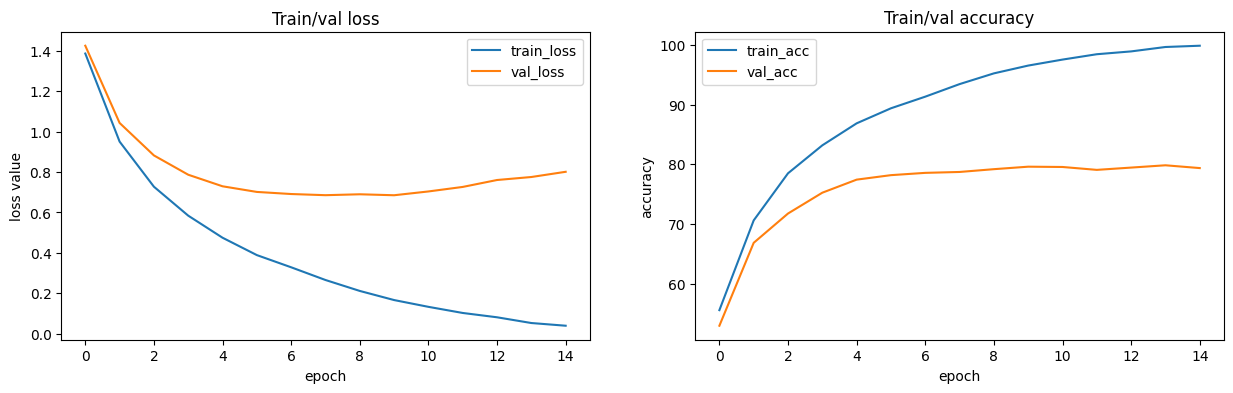

Best Epoch: 14 Average loss: 0.7751029444501755 Accuracy: 79.83333333333333
Epoch 1/15: train_loss: 0.9456, train_accuracy: 70.7222, val_loss: 1.0227, val_accuracy: 66.8833
Epoch 2/15: train_loss: 0.5618, train_accuracy: 83.7278, val_loss: 0.6989, val_accuracy: 78.4500
Epoch 3/15: train_loss: 0.3748, train_accuracy: 89.7333, val_loss: 0.5860, val_accuracy: 81.9167
Epoch 4/15: train_loss: 0.2598, train_accuracy: 93.4426, val_loss: 0.5473, val_accuracy: 83.5333
Epoch 5/15: train_loss: 0.1683, train_accuracy: 96.1870, val_loss: 0.5295, val_accuracy: 83.7667
Epoch 6/15: train_loss: 0.1104, train_accuracy: 97.8407, val_loss: 0.5365, val_accuracy: 84.0333
Epoch 7/15: train_loss: 0.0627, train_accuracy: 99.1407, val_loss: 0.5527, val_accuracy: 84.4833
Epoch 8/15: train_loss: 0.0327, train_accuracy: 99.7537, val_loss: 0.5710, val_accuracy: 84.6167
Epoch 9/15: train_loss: 0.0206, train_accuracy: 99.9204, val_loss: 0.6130, val_accuracy: 84.6333
Epoch 10/15: train_loss: 0.0113, train_accuracy: 99

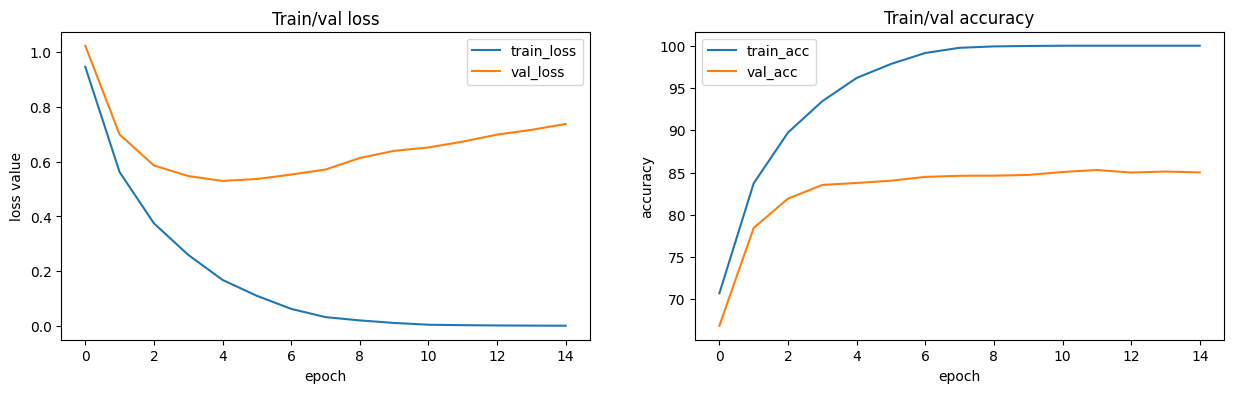

Best Epoch: 12 Average loss: 0.6728607003993177 Accuracy: 85.3
Epoch 1/15: train_loss: 2.2923, train_accuracy: 13.7926, val_loss: 2.3055, val_accuracy: 12.0167
Epoch 2/15: train_loss: 2.2882, train_accuracy: 12.8963, val_loss: 2.3104, val_accuracy: 10.0500
Epoch 3/15: train_loss: 2.2794, train_accuracy: 14.7259, val_loss: 2.3109, val_accuracy: 11.0667
Epoch 4/15: train_loss: 2.2736, train_accuracy: 15.7500, val_loss: 2.3137, val_accuracy: 11.1500
Epoch 5/15: train_loss: 2.2708, train_accuracy: 14.9241, val_loss: 2.3239, val_accuracy: 10.9833
Epoch 6/15: train_loss: 2.2627, train_accuracy: 16.3556, val_loss: 2.3208, val_accuracy: 11.0500
Epoch 7/15: train_loss: 2.2611, train_accuracy: 15.4907, val_loss: 2.3296, val_accuracy: 10.4333
Epoch 8/15: train_loss: 2.2523, train_accuracy: 16.6556, val_loss: 2.3342, val_accuracy: 10.5000
Epoch 9/15: train_loss: 2.2492, train_accuracy: 17.2889, val_loss: 2.3334, val_accuracy: 10.6500
Epoch 10/15: train_loss: 2.2438, train_accuracy: 17.4222, val_lo

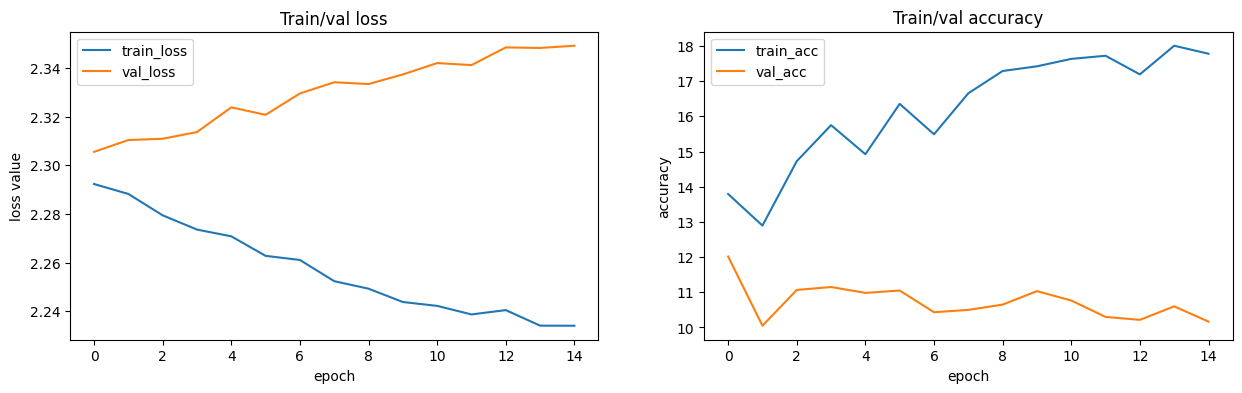

Best Epoch: 1 Average loss: 2.305547298269069 Accuracy: 12.016666666666667


In [15]:
loss_fn = nn.CrossEntropyLoss()

model1 = Model01()
model1 = model1.to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_both_results1 = train_model("train_both1", train_both_loader, val_both_loader, model1, optimizer1, loss_fn, 15, Model01)
plot_results(train_both_results1, test_both_loader, val_both_loader)

model2 = Model02()
model2 = model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_both_results2 = train_model("train_both2", train_both_loader, val_both_loader, model2, optimizer2, loss_fn, 15, Model02)
plot_results(train_both_results2, test_both_loader, val_both_loader)

model3 = Model03()
model3 = model3.to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_both_results3 = train_model("train_both3", train_both_loader, val_both_loader, model3, optimizer3, loss_fn, 15, Model03)
plot_results(train_both_results3, test_both_loader, val_both_loader)

##  Task 5. Evaluation

From the previously selected models select the one that shows the best results on the validation set. Let's denote this as the best model. How can you explain the differences in the accuracies of the models trained on different training sets?


In [16]:
m_loss1, accuracy1 = evaluate_model(model1, test_both_loader, loss_fn)
print("Average loss 1:", m_loss1, "Accuracy 1:", accuracy1)
m_loss2, accuracy2 = evaluate_model(model2, test_both_loader, loss_fn)
print("Average loss 2:", m_loss2, "Accuracy 2:", accuracy2)
m_loss3, accuracy3 = evaluate_model(model3, test_both_loader, loss_fn)
print("Average loss 3:", m_loss3, "Accuracy 3:", accuracy3)

Average loss 1: 0.7815546944171567 Accuracy 1: 79.5
Average loss 2: 0.7330837694904472 Accuracy 2: 84.92
Average loss 3: 2.34364001056816 Accuracy 3: 10.18


Report the accuracy of the best model on the test set.

In [17]:
m_loss2, accuracy2 = evaluate_model(model2, test_both_loader, loss_fn)
print("Average loss 2:", m_loss2, "Accuracy 2:", accuracy2)

Average loss 2: 0.7330837694904472 Accuracy 2: 84.92


## Task 6. Visualizations

Visualize some examples of the best model's successful and failure predictions on the test set. Visualize the accuaracy depending on the digit pairs. Why is the model better or worse on some digits? 

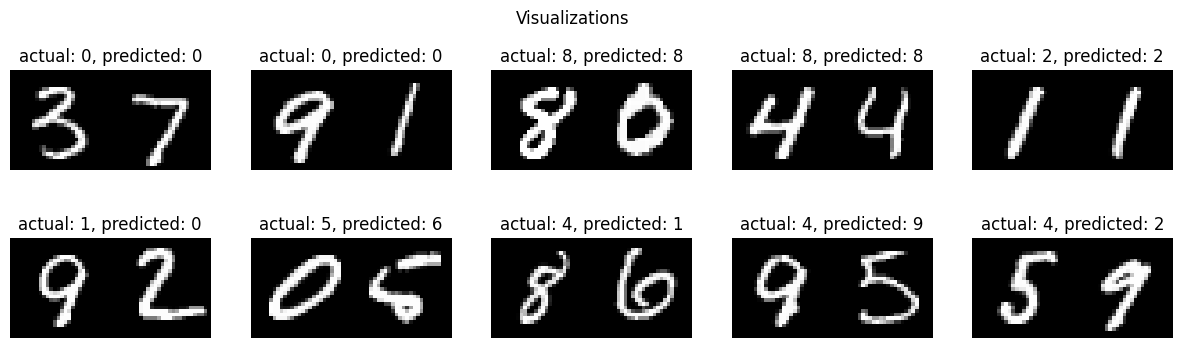

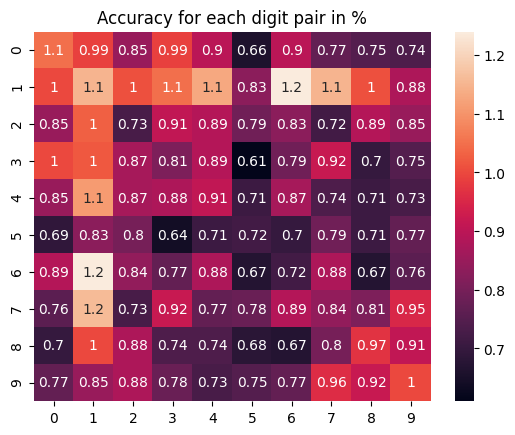

In [33]:
_t_mean=[0.5, 0.5, 0.5]
_t_std=[0.5, 0.5, 0.5]

def show_validation_errors(taskname,model_class,test_loader):
    model = model_class()
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far_true = 0
    images_so_far_false = 0
    plt.subplots(2,5,figsize=(15,4))
    plt.suptitle('Visualizations')

    accuracy_heat = np.zeros((10,10))

    def _imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        plt.imshow(inp)
        if title is not None:
            plt.title(title)

    with torch.no_grad():
        for iteration, (images, labels, first_label, second_label) in enumerate((test_loader)):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                #Gather data for heatmap
                #print(labels.cpu().data[j], preds[j], "next")
                if(labels.data[j] == preds[j]):
                    accuracy_heat[first_label[j], second_label[j]] += 1

                #Get images for visualization
                if images_so_far_true <= 5 and images_so_far_false <= 5:
                    sel_axs = None
                    if(labels.data[j] == preds[j]):
                        if (images_so_far_true == 5):
                            continue
                        else:
                            images_so_far_true += 1
                            plt.subplot(2,5,images_so_far_true)
                    else:
                        if (images_so_far_false == 5):
                            continue
                        else:
                            images_so_far_false += 1
                            plt.subplot(2,5,images_so_far_false+5)

                    
                    plt.axis('off')
                    plt.title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                    _imshow(images.cpu().data[j])

        accuracy_heat /= len(test_loader.dataset)
        accuracy_heat *= 100

        plt.show()
        plt.rcdefaults()
        plt.title("Accuracy for each digit pair in %")
        sns.heatmap(accuracy_heat, annot=True)
        plt.show()
        plt.rcdefaults()


show_validation_errors("train_both2", Model02, test_both_loader)

In [19]:
!cp 'dataset.py' '/content/drive/My Drive/ATML/Assignments/Assignment1/'